# Validation: MCMC stability

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* plots the rhat statistic for the mcmc

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

sns.set_style("ticks")
%matplotlib inline

In [10]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


In [ ]:
def calc_trace_statistic(model, stat_type):
    if stat_type=='rhat':
        stat = az.rhat(model.trace)
    if stat_type=='ess':
        stat = az.ess(model.trace, relative=True)
    stat_all = []
    stat_nums = []
    print(model.vars)
    for i in range(len(model.vars)):
        var = model.vars[i]
        if str(var)[-6:-1]=='_log_':
            var = str(var)[0:-6]
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
    return stat_all

### Build and run models

Calculate and save the r-hat and ess values for each random variable

In [4]:
model_types = ['combined', 'active', 'death']

In [ ]:
for model_type in model_types:
    print('Model: ' + str(model_type))
    if model_type=='combined':
        with cm_effect.models.CMCombined_Final(data) as model:
            model.build_model()  
    if model_type=='active':
        with cm_effect.models.CMActive_Final(data) as model:
            model.build_model()  
    if model_type=='death':
        with cm_effect.models.CMDeath_Final(data) as model:
            model.build_model()                      

    model.run(1000, chains=8, cores=8)
    rhats = calc_trace_statistic(model,'rhat')
    ess = calc_trace_statistic(model,'ess')
    
    np.savetxt('out_final/rhats_'+ model_type + '.txt',rhats)
    np.savetxt('out_final/ess_'+ model_type + '.txt',ess)
    filename = 'out_final/default_' + model_type + '.txt'
    cm_trace = model.trace["CMReduction"]
    np.savetxt(filename, cm_trace)

### Plotting

In [11]:
def plot_histogram_model_stat(stat_list, labels, colors, fontsize=12, bin_nums=[None, None, None]):
    plt.figure()
    for i in range(len(stat_list)):
        sns.distplot(stat_list[i], kde=False, hist_kws={"alpha": 0.5}, label = labels[i], 
                     color=colors[i], bins=bin_nums[i])
        plt.ylabel('Count')
        sns.despine()
        plt.tight_layout()
        plt.rc('font', size=fontsize)
        plt.legend(frameon=False)
    plt.tight_layout()

In [12]:
labels = ['Deaths','Active Cases','Combined']
colors = ['tab:red', 'tab:blue', 'tab:purple']

##### plot rhat

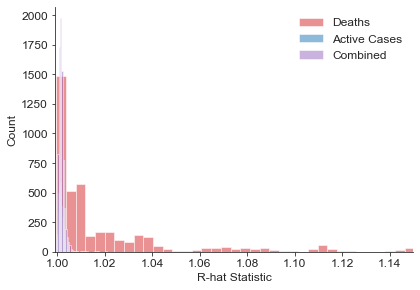

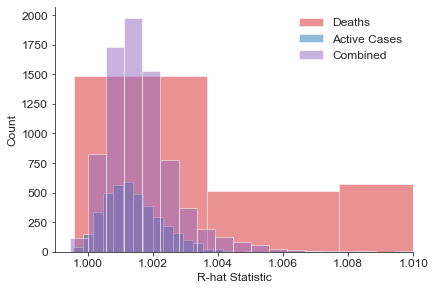

In [25]:
rhats_deaths= np.loadtxt('out_final/rhats_death.txt')
rhats_active= np.loadtxt('out_final/rhats_active.txt')
rhats_combined= np.loadtxt('out_final/rhats_combined.txt')
    
plot_histogram_model_stat([rhats_deaths, rhats_active , rhats_combined], labels, colors)
plt.xlabel('R-hat Statistic')
plt.xlim([0.999, 1.15])
plt.savefig('out_final/rhat_dist_all.pdf')

plot_histogram_model_stat([rhats_deaths, rhats_active , rhats_combined], labels, colors)
plt.xlabel('R-hat Statistic')
plt.xlim([0.999, 1.01])
plt.savefig('out_final/rhat_dist_all_zoom.pdf')

##### plot ess

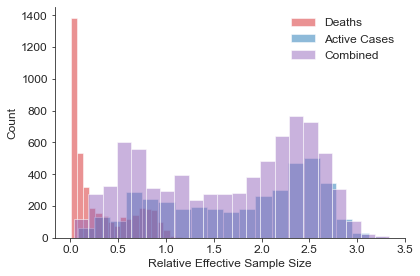

In [21]:
ess_deaths= np.loadtxt('out_final/ess_death.txt')
ess_active= np.loadtxt('out_final/ess_active.txt')
ess_combined= np.loadtxt('out_final/ess_combined.txt')

plot_histogram_model_stat([ess_deaths,ess_active,ess_combined], labels, colors)
plt.xlabel('Relative Effective Sample Size')
plt.tight_layout()
plt.savefig('out_final/ess_dist_all.pdf')